Aath warning: anndata is stateful, so seems incompatible with jupyter notebook design. Run cells in order and beware rerunning cells/running things out of order.

In [1]:
import scanpy as sc
import scvi
import pandas as pd
from scvi.external import MRVI

/Users/aathreyakadambi/Documents/software/python/anaconda/anaconda3/envs/omics/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# gene expression processing

## preprocessing

In [2]:
# data source: # https://www.biorxiv.org/content/10.1101/2025.09.11.675724v1.full - PacBio long reads
# files paths 

CARMELLE_DATA_DIR = "/mnt/lareaulab/carmelle/longread_sc/lung"
AATH_DATA_DIR = "/Users/aathreyakadambi/Documents/school/berkeley/fa25/cs194/final_project/data"
DATA_DIR = AATH_DATA_DIR

# sn
sn_gene = f'{DATA_DIR}/sn/GSM9135509_pb_sn_genes_count_matrix.tsv.gz'
sn_isoform = f'{DATA_DIR}/sn/GSM9135509_pb_sn_transcript_count_matrix.mtx.gz'

# sc
sc_gene = f'{DATA_DIR}/sc/GSM9135508_pb_sc_genes_count_matrix.tsv.gz'
sc_isoform = f'{DATA_DIR}/sc/GSM9135508_pb_sc_transcript_count_matrix.mtx.gz'

In [3]:
adata_sn_gene = sc.read_csv(sn_gene).transpose()
adata_sc_gene = sc.read_csv(sc_gene).transpose()

In [4]:
adata_sn_gene, adata_sc_gene

(AnnData object with n_obs × n_vars = 10001 × 49671,
 AnnData object with n_obs × n_vars = 5002 × 50394)

In [5]:
adata_sn_gene.var_names, adata_sc_gene.var_names

(Index(['ENSG00000211952.3', 'ENSG00000211955.2', 'ENSG00000211956.2',
        'ENSG00000211957.2', 'ENSG00000211958.2', 'ENSG00000211959.2',
        'ENSG00000231475.3', 'ENSG00000238275.2', 'ENSG00000253240.1',
        'ENSG00000253325.1',
        ...
        'ENSG00000283791.1', 'ENSG00000285533.4', 'ENSG00000286756.3',
        'ENSG00000289259.2', 'ENSG00000289339.2', 'ENSG00000289740.1',
        'ENSG00000289883.1', 'ENSG00000290026.1', 'ENSG00000290061.1',
        'ENSG00000291174.1'],
       dtype='object', length=49671),
 Index(['ENSG00000212380.1', 'ENSG00000270814.1', 'ENSG00000280234.1',
        'ENSG00000211938.2', 'ENSG00000211943.2', 'ENSG00000211947.2',
        'ENSG00000211949.3', 'ENSG00000211950.2', 'ENSG00000211952.3',
        'ENSG00000211955.2',
        ...
        'ENSG00000210174.1', 'ENSG00000210176.1', 'ENSG00000210184.1',
        'ENSG00000210191.1', 'ENSG00000210194.1', 'ENSG00000210195.2',
        'ENSG00000210196.2', 'ENSG00000211459.2', 'ENSG00000212907.2'

## check some qc metrics

In [6]:
sc.pp.calculate_qc_metrics(adata_sc_gene, inplace=True)
sc.pp.calculate_qc_metrics(adata_sn_gene, inplace=True)

In [7]:
#looks good
adata_sn_gene.obs['n_genes_by_counts'].mean(), adata_sc_gene.obs['n_genes_by_counts'].mean()

(np.float64(4348.82201779822), np.float64(7170.528988404638))

## concatenate datasets

In [8]:
#add batch labels
adata_sn_gene.obs['batch'] = 'single nuclei'
adata_sc_gene.obs['batch'] = 'single cell'


In [9]:
type(adata_sn_gene.X)

numpy.ndarray

In [10]:
adata_sc_gene.var_names

Index(['ENSG00000212380.1', 'ENSG00000270814.1', 'ENSG00000280234.1',
       'ENSG00000211938.2', 'ENSG00000211943.2', 'ENSG00000211947.2',
       'ENSG00000211949.3', 'ENSG00000211950.2', 'ENSG00000211952.3',
       'ENSG00000211955.2',
       ...
       'ENSG00000210174.1', 'ENSG00000210176.1', 'ENSG00000210184.1',
       'ENSG00000210191.1', 'ENSG00000210194.1', 'ENSG00000210195.2',
       'ENSG00000210196.2', 'ENSG00000211459.2', 'ENSG00000212907.2',
       'ENSG00000228253.1'],
      dtype='object', length=50394)

In [11]:
#no repeat barcodes 

adata_sn_gene.obs_names_make_unique()
adata_sc_gene.obs_names_make_unique()

#no repeat features
adata_sn_gene.var_names_make_unique()
adata_sc_gene.var_names_make_unique()


In [12]:
genes_combined = sc.concat([adata_sc_gene, adata_sn_gene], 
                   join='inner', 
                   label='dataset',
                   keys=['single cell', 'single nuclei'])

/Users/aathreyakadambi/Documents/software/python/anaconda/anaconda3/envs/omics/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [13]:
genes_combined

AnnData object with n_obs × n_vars = 15003 × 47134
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'batch', 'dataset'

In [14]:
#no repeat barcodes in integrated dataset

genes_combined.obs_names_make_unique()

In [15]:
genes_combined.obs['n_genes_by_counts'].mean()

np.float64(5289.579084183163)

In [16]:
genes_combined

AnnData object with n_obs × n_vars = 15003 × 47134
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'batch', 'dataset'

In [17]:
genes_combined.obs['batch'].value_counts()

batch
single nuclei    10001
single cell       5002
Name: count, dtype: int64

In [18]:
sc.pp.filter_cells(genes_combined, min_genes=100)
sc.pp.filter_genes(genes_combined, min_cells=3)

#print after filtering
genes_combined

AnnData object with n_obs × n_vars = 15003 × 46294
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'batch', 'dataset', 'n_genes'
    var: 'n_cells'

In [19]:
# run scvi on raw counts
genes_combined.layers['counts'] = genes_combined.X

## visualize without correcting for batch effect

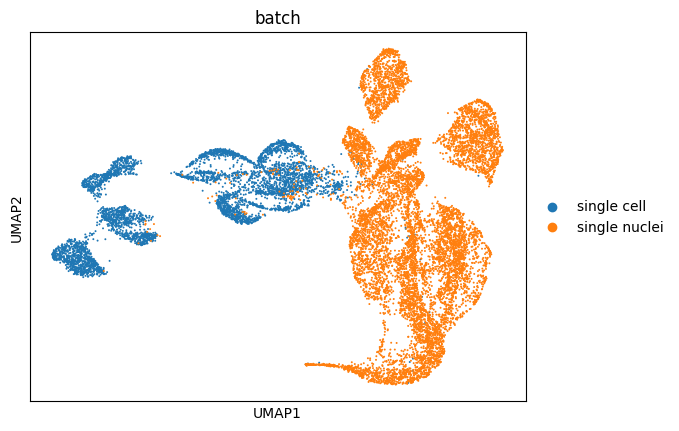

In [20]:
sc.tl.pca(genes_combined)
sc.pp.neighbors(genes_combined, n_pcs=30, n_neighbors=15)
sc.tl.umap(genes_combined, min_dist=0.3)
sc.pl.umap(genes_combined, color=['batch'], wspace=0.55)

## scVI

In [21]:
sc.pp.highly_variable_genes(
    genes_combined,
    n_top_genes=10000,
    subset=True,
    layer="counts",
    flavor="cell_ranger",
)

In [22]:
scvi.model.SCVI.setup_anndata(
    genes_combined,
    layer="counts",
    batch_key="batch",
)

In [21]:
model = scvi.model.SCVI(genes_combined)
model

SCVI model with the following parameters: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal.
Training status: Not Trained
Model's adata is minified?: False

In [23]:
genes_combined.obs

,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,batch,dataset,n_genes
AACAAGAGTGCCGGTT,10203,9.230535,53044.0,10.878896,19.668577,26.623181,34.307367,45.630043,single cell,single cell,10187
ACAACCAGTTCCTAGA,12122,9.402860,57040.0,10.951526,11.279804,16.640954,23.318724,33.792076,single cell,single cell,12099
ACCATTTCACAAGCTT,10260,9.236106,63070.0,11.052016,18.187728,24.420485,32.473442,44.133502,single cell,single cell,10237
ACTACGAAGTTCGGTT,5441,8.601902,15845.0,9.670672,23.792995,30.255601,37.595456,49.441464,single cell,single cell,5436
ACTTAGGAGCCTATCA,14052,9.550591,85072.0,11.351265,12.052144,16.168657,21.732180,32.075183,single cell,single cell,14012
...,...,...,...,...,...,...,...,...,...,...,...
GTGTAACCAATCGCAT,2526,7.834788,3731.0,8.224700,10.720986,16.429912,24.551059,41.543822,single nuclei,single nuclei,2524
TACCGAAAGACCTCCG,2918,7.978996,4947.0,8.506739,16.191631,20.820699,28.198908,43.561755,single nuclei,single nuclei,2912
TCGACCTTCAAAGAAC,3199,8.070906,5412.0,8.596559,15.428677,20.251293,27.716186,42.184035,single nuclei,single nuclei,3196
TCTTTGACAAATTAGG,2904,7.974189,4759.0,8.468003,11.809204,17.629754,25.929817,42.109687,single nuclei,single nuclei,2902


In [23]:
MRVI.setup_anndata(
    genes_combined,
    batch_key="batch"
)

In [24]:
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"
os.environ["JAX_DISABLE_MOST_OPTIMIZATIONS"] = "1"

In [25]:
model = MRVI(genes_combined, )

W0000 00:00:1765451599.802616 1885333 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1765451599.834005 1885333 service.cc:145] XLA service 0x33e1dc220 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765451599.834038 1885333 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1765451599.836326 1885333 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1765451599.836347 1885333 mps_client.cc:384] XLA backend will use up to 17179492352 bytes on device 0 for SimpleAllocator.


Metal device set to: Apple M2

systemMemory: 24.00 GB
maxCacheSize: 8.00 GB



XlaRuntimeError: UNIMPLEMENTED: default_memory_space is not supported.

In [ ]:
model.train(max_epochs=200,
    accelerator="cpu",
    devices=1,
    strategy="ddp_notebook_find_unused_parameters_true")

/Users/aathreyakadambi/Documents/software/python/anaconda/anaconda3/envs/omics/lib/python3.10/site-packages/scvi/train/_trainrunner.py:81: UserWarning: early_stopping was automaticaly disabled due to the use of DDP
  self.trainer = self._trainer_cls(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/aathreyakadambi/Documents/software/python/anaconda/anaconda3/envs/omics/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/1
----------------------------------------------------------------------------------------------------
distributed_backend=gloo
All distributed processes registered. Starting with 1 processes
----------------------------------------------------------------------------------------------------

/Users/aathreyakadambi/Documents/software/python/anaconda/anaconda3/envs/omics/lib/python3.10

Epoch 28/200:  14%|█▎        | 27/200 [06:40<42:49, 14.86s/it, v_num=1, train_loss_step=3.08e+3, train_loss_epoch=2.87e+3]

In [ ]:
SCVI_LATENT_KEY = "X_scVI"

latent = model.get_latent_representation()
genes_combined.obsm[SCVI_LATENT_KEY] = latent
latent.shape

(15003, 10)

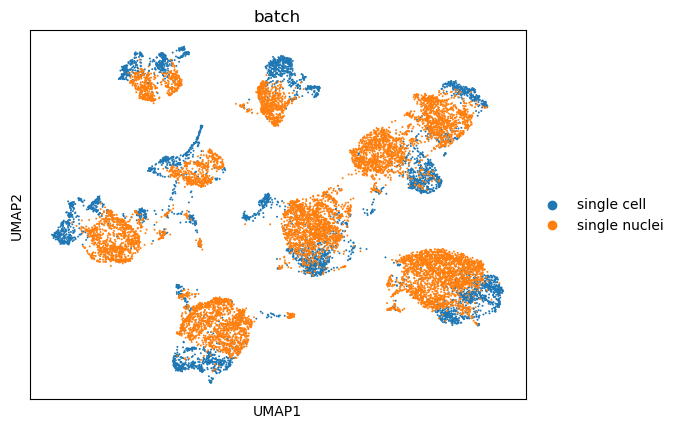

In [ ]:
sc.pp.neighbors(genes_combined, use_rep=SCVI_LATENT_KEY)
sc.tl.umap(genes_combined, min_dist=0.3)
sc.pl.umap(genes_combined, color=['batch'], wspace=0.55)

## integrated gene expression data

In [ ]:
genes_combined.obs['n_genes_by_counts'].mean()

np.float64(5289.579084183163)

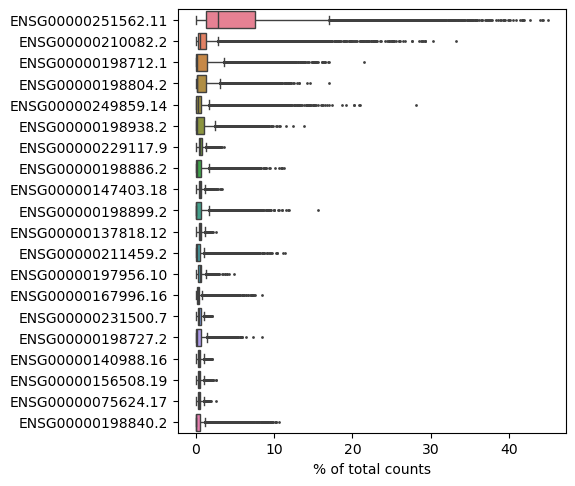

In [ ]:
sc.pl.highest_expr_genes(genes_combined, n_top=20)

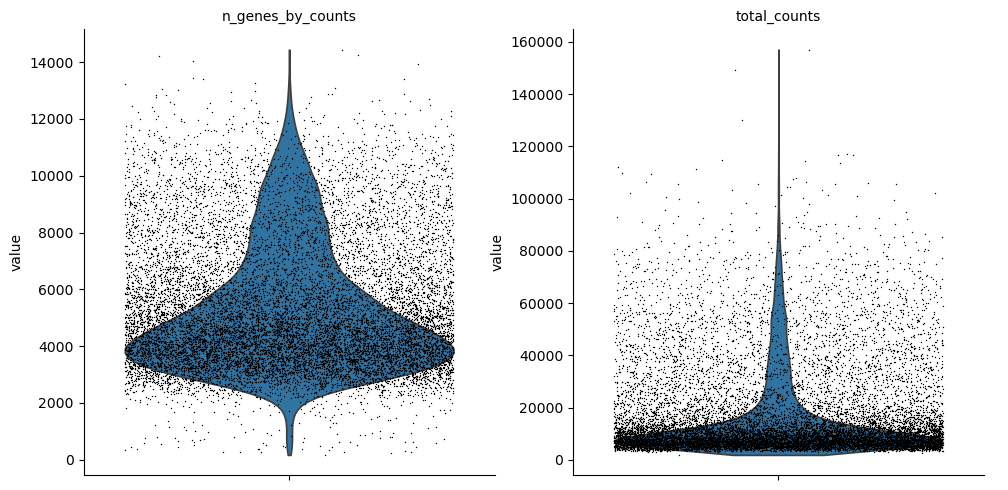

In [ ]:
sc.pl.violin(
    genes_combined,
    ["n_genes_by_counts", "total_counts"],
    jitter=0.4,
    multi_panel=True,
)

## leiden

In [ ]:
sc.tl.leiden(genes_combined, resolution=0.3)

/tmp/ipykernel_3694823/2127173360.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(genes_combined, resolution=0.3)


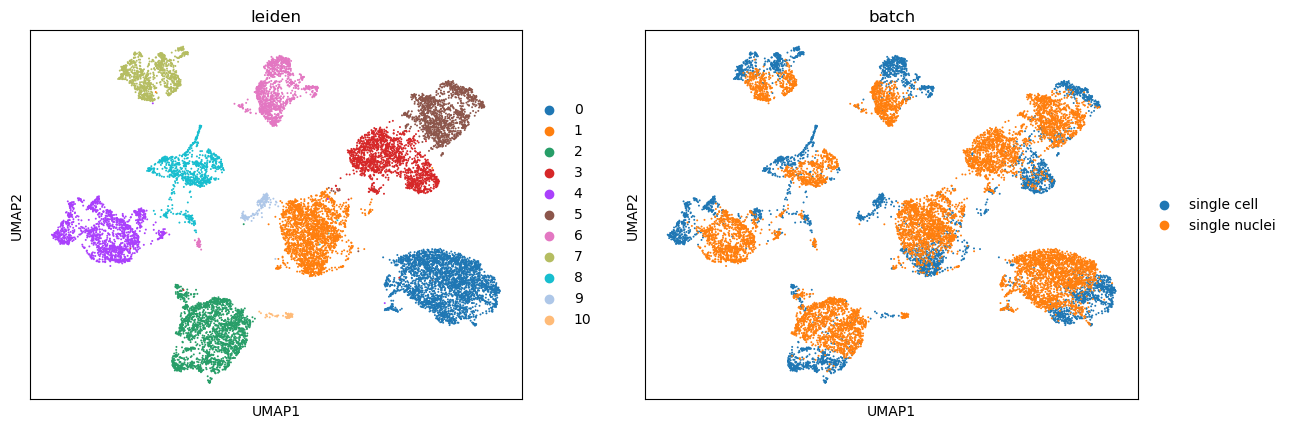

In [ ]:
#visualize

sc.pl.umap(genes_combined, color=['leiden', 'batch'])

In [ ]:
sc.pp.log1p(genes_combined)

In [ ]:
sc.tl.rank_genes_groups(genes_combined, groupby='leiden', method='wilcoxon')

# add isoform expression

## preprocessing

In [23]:
adata_sn_isoform = sc.read_mtx(sn_isoform)
adata_sc_isoform = sc.read_mtx(sc_isoform)

In [24]:
adata_sn_isoform, adata_sc_isoform

(AnnData object with n_obs × n_vars = 10001 × 127013,
 AnnData object with n_obs × n_vars = 5002 × 128580)

In [37]:
adata_sc_isoform.X

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 44406476 stored elements and shape (5002, 128580)>

In [38]:
adata_sn_isoform.X

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 37515983 stored elements and shape (10001, 127013)>

In [28]:
sn_features = pd.read_csv(f'{DATA_DIR}/sn/GSM9135509_pb_sn_transcript_count_features.tsv.gz', header=None)[0].tolist()
sn_cells = pd.read_csv(f'{DATA_DIR}/sn/GSM9135509_pb_sn_transcript_count_barcodes.tsv.gz', header=None)[0].tolist()

In [30]:
sc_features = pd.read_csv(f'{DATA_DIR}/sc/GSM9135508_pb_sc_transcript_count_features.tsv.gz', header=None)[0].tolist()
sc_cells = pd.read_csv(f'{DATA_DIR}/sc/GSM9135508_pb_sc_transcript_count_barcodes.tsv.gz', header=None)[0].tolist()

In [31]:
adata_sn_isoform.var_names = sn_features
adata_sn_isoform.obs_names = sn_cells

In [32]:
adata_sc_isoform.var_names = sc_features
adata_sc_isoform.obs_names = sc_cells

In [33]:
adata_sc_isoform.var_names[:10], adata_sc_isoform.obs_names[:10]

(Index(['ENST00000456328.2', 'ENST00000473358.1', 'ENST00000469289.1',
        'ENST00000606857.1', 'ENST00000442987.3', 'ENST00000496488.1',
        'ENST00000669836.1', 'ENST00000635159.1', 'ENST00000423796.1',
        'ENST00000416931.1'],
       dtype='object'),
 Index(['AAACCCAAGCCTGACC', 'AAACCCACAACTCATG', 'AAACCCACATCTAACG',
        'AAACCCATCAACCTTT', 'AAACGAAGTCATAACC', 'AAACCCAAGAACTCCT',
        'AAACCCACATCATCTT', 'AAACCCAGTCCACAGC', 'AAACGAAAGTGGGAAA',
        'AAACGAATCTTAGCTT'],
       dtype='object'))

In [ ]:
adata_sn_isoform.var_names[:10], adata_sn_isoform.obs_names[:10]

(Index(['ENST00000456328.2', 'ENST00000642116.1', 'ENST00000641515.2',
        'ENST00000442987.3', 'ENST00000496488.1', 'ENST00000669836.1',
        'ENST00000635159.1', 'ENST00000432723.3', 'ENST00000423796.1',
        'ENST00000416931.1'],
       dtype='object'),
 Index(['AAACCCACAACCGACC', 'AAACCCACATCCGAGC', 'AAACCCAGTACAGAAT',
        'AAACCCAAGTTAACAG', 'AAACCCAGTAGCTGCC', 'AAACCCATCTAGTACG',
        'AAACCCAGTTCCACAA', 'AAACGAAAGCGTCTCG', 'AAACCCAGTCGCACAC',
        'AAACGAAAGTTCTCTT'],
       dtype='object'))

## check some qc metrics

In [ ]:
sc.pp.calculate_qc_metrics(adata_sc_isoform, inplace=True)
sc.pp.calculate_qc_metrics(adata_sn_isoform, inplace=True)

In [ ]:
adata_sn_isoform, adata_sc_isoform

(AnnData object with n_obs × n_vars = 10001 × 127013
     obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
     var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts',
 AnnData object with n_obs × n_vars = 5002 × 128580
     obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
     var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts')

In [ ]:
# isoforms looks okay... similar mean counts per dataset. slightly higher?
adata_sn_isoform.obs['n_genes_by_counts'].mean(), adata_sc_isoform.obs['n_genes_by_counts'].mean()

(np.float64(3751.223177682232), np.float64(8877.744102359056))

## concatenate datasets

In [ ]:
#add batch labels
adata_sn_isoform.obs['batch'] = 'single nuclei'
adata_sc_isoform.obs['batch'] = 'single cell'


In [ ]:
#no repeat barcodes 

adata_sn_isoform.obs_names_make_unique()
adata_sc_isoform.obs_names_make_unique()

#no repeat features
adata_sn_isoform.var_names_make_unique()
adata_sc_isoform.var_names_make_unique()


In [ ]:
isoforms_combined = sc.concat([adata_sc_isoform, adata_sn_isoform], 
                   join='inner', 
                   label='dataset',
                   keys=['single cell', 'single nuclei'])

/mnt/lareaulab/carmelle/bin/anaconda3/envs/myscvi/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [ ]:
isoforms_combined

AnnData object with n_obs × n_vars = 15003 × 105477
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'batch', 'dataset'

In [ ]:
#no repeat barcodes in integrated dataset

isoforms_combined.obs_names_make_unique()

In [ ]:
isoforms_combined.obs['n_genes_by_counts'].mean()

np.float64(5460.405185629541)

In [ ]:
isoforms_combined

AnnData object with n_obs × n_vars = 15003 × 105477
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'batch', 'dataset'

In [ ]:
isoforms_combined.obs['batch'].value_counts()

batch
single nuclei    10001
single cell       5002
Name: count, dtype: int64

In [ ]:
sc.pp.filter_cells(isoforms_combined, min_genes=100)
sc.pp.filter_genes(isoforms_combined, min_cells=3)

#print after filtering
isoforms_combined

AnnData object with n_obs × n_vars = 15003 × 100589
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'batch', 'dataset', 'n_genes'
    var: 'n_cells'

In [ ]:
isoforms_combined.obs['n_genes_by_counts'].mean()

np.float64(5460.405185629541)

In [ ]:
# run scvi on raw counts
isoforms_combined.layers['counts'] = isoforms_combined.X

## combined isoform expression 

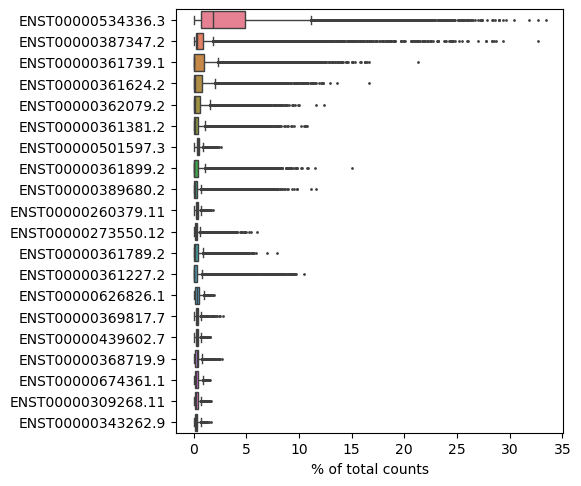

In [ ]:
sc.pl.highest_expr_genes(isoforms_combined, n_top=20)

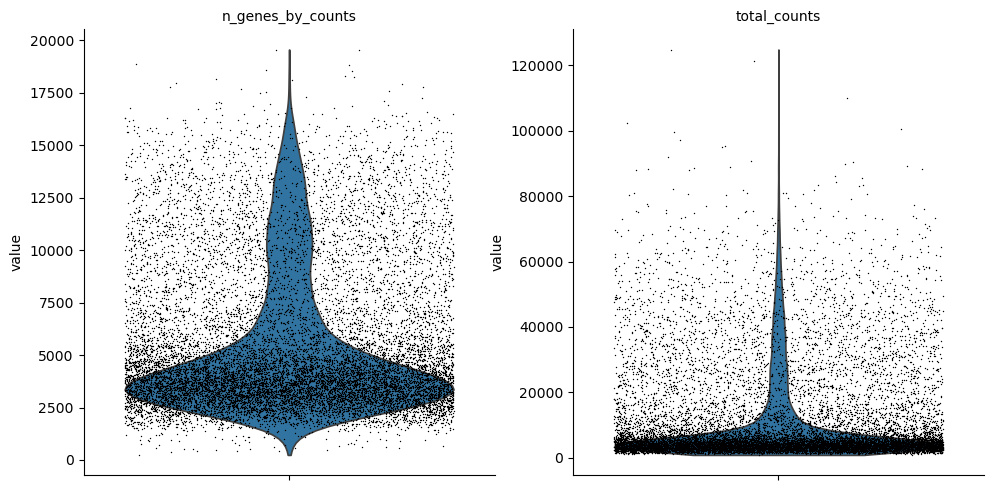

In [ ]:
sc.pl.violin(
    isoforms_combined,
    ["n_genes_by_counts", "total_counts"],
    jitter=0.4,
    multi_panel=True,
)

In [ ]:
# all the cells are matched 
isoforms_combined_reordered = isoforms_combined[genes_combined.obs_names, :]
pd.Series(genes_combined.obs_names == isoforms_combined_reordered.obs_names).value_counts()

True    15003
Name: count, dtype: int64

In [ ]:
isoforms_combined = isoforms_combined_reordered

In [ ]:
isoforms_combined.layers['counts'] = isoforms_combined_reordered.X

/tmp/ipykernel_3694823/14383567.py:1: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  isoforms_combined.layers['counts'] = isoforms_combined_reordered.X


In [ ]:
isoforms_combined.write_h5ad('integrated_sc_sn_iso-exp.h5ad')

In [ ]:
genes_combined.write_h5ad('integrated_sc_sn_gene-exp.h5ad')

## scVI on isoform data

In [ ]:
#restart kernel here

import scanpy as sc
import scvi
import pandas as pd

In [ ]:
isoforms_combined = sc.read_h5ad('integrated_sc_sn_iso-exp.h5ad')
genes_combined = sc.read_h5ad('integrated_sc_sn_gene-exp.h5ad')

In [ ]:
scvi.model.SCVI.setup_anndata(
    isoforms_combined,
    layer="counts",
    batch_key="batch",
)

/mnt/lareaulab/carmelle/bin/anaconda3/envs/myscvi/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


In [ ]:
model = scvi.model.SCVI(isoforms_combined)
model

SCVI model with the following parameters: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal.
Training status: Not Trained
Model's adata is minified?: False

In [ ]:
model.train(max_epochs=500,
            accelerator="gpu",
            devices=-1,
            strategy="ddp_notebook_find_unused_parameters_true")

/mnt/lareaulab/carmelle/bin/anaconda3/envs/myscvi/lib/python3.10/site-packages/scvi/train/_trainrunner.py:81: UserWarning: early_stopping was automaticaly disabled due to the use of DDP
  self.trainer = self._trainer_cls(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
You are using a CUDA device ('NVIDIA A100 80GB PCIe') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/1
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 1 processes
--------------------------------------------------------------------------------------------

Training:   0%|          | 0/500 [00:00<?, ?it/s]

/mnt/lareaulab/carmelle/bin/anaconda3/envs/myscvi/lib/python3.10/site-packages/scvi/module/_vae.py:570: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/mnt/lareaulab/carmelle/bin/anaconda3/envs/myscvi/lib/python3.10/site-packages/scvi/module/_vae.py:570: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/mnt/lareaulab/carmelle/bin/anaconda3/envs/myscvi/lib/python3.10/site-packages/scvi/module/_vae.py:570: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/mnt/lareaulab/carmelle/bin/anaconda3/envs/myscvi/lib/python3.10/site-packages/scvi/module/_vae.py:570: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[

In [ ]:
SCVI_LATENT_KEY = "X_scVI"

latent = model.get_latent_representation()
isoforms_combined.obsm[SCVI_LATENT_KEY] = latent
latent.shape

(15003, 10)

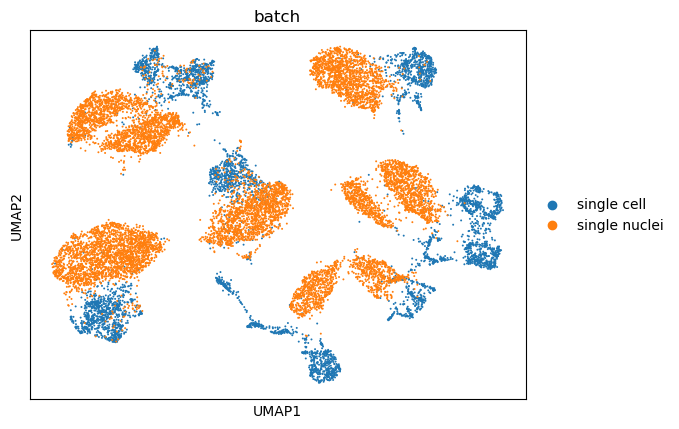

In [ ]:
sc.pp.neighbors(isoforms_combined, use_rep=SCVI_LATENT_KEY)
sc.tl.umap(isoforms_combined, min_dist=0.3)
sc.pl.umap(isoforms_combined, color=['batch'], wspace=0.55)

## leiden on isoform data

In [ ]:
sc.tl.leiden(isoforms_combined, resolution=0.2)

/tmp/ipykernel_3711152/2952658760.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(isoforms_combined, resolution=0.2)


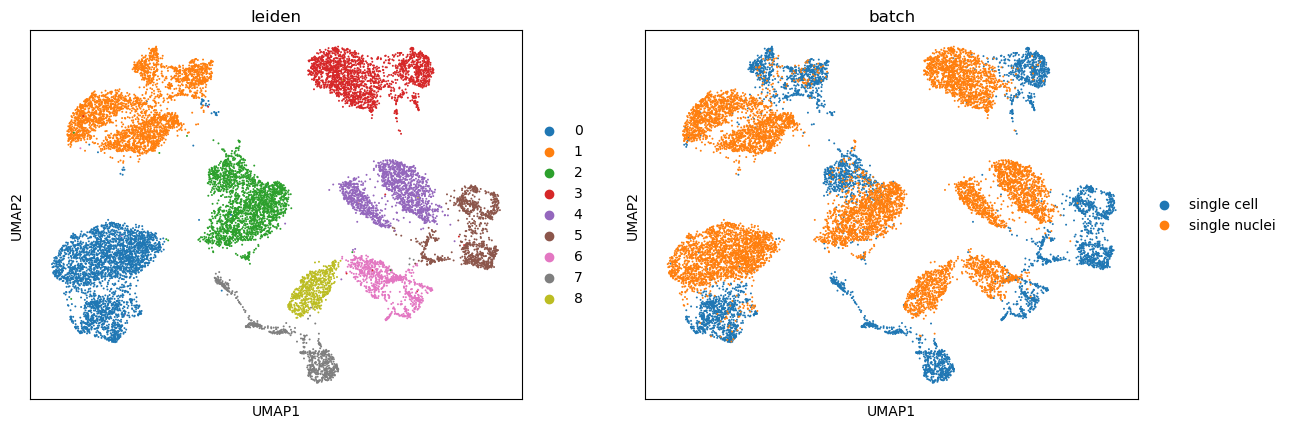

In [ ]:
#visualize

sc.pl.umap(isoforms_combined, color=['leiden', 'batch'])

# combine gene and isoform anndata

In [ ]:
import mudata as md

In [ ]:
# make sure the cell barcodes are the same
pd.Series(genes_combined.obs_names == isoforms_combined.obs_names).value_counts()

True    15003
Name: count, dtype: int64

In [ ]:
# add isoform to gene anndata
gene_isoform_combined = md.MuData({'gene': genes_combined, 'isoform': isoforms_combined})
gene_isoform_combined

/mnt/lareaulab/carmelle/bin/anaconda3/envs/myscvi/lib/python3.10/site-packages/mudata/_core/mudata.py:1598: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/mnt/lareaulab/carmelle/bin/anaconda3/envs/myscvi/lib/python3.10/site-packages/mudata/_core/mudata.py:1461: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


MuData object with n_obs × n_vars = 15003 × 146883
  var:	'n_cells'
  2 modalities
    gene:	15003 x 46294
      obs:	'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'batch', 'dataset', 'n_genes', '_scvi_batch', '_scvi_labels', 'leiden'
      var:	'n_cells'
      uns:	'pca', 'neighbors', 'umap', 'batch_colors', '_scvi_uuid', '_scvi_manager_uuid', 'leiden', 'leiden_colors', 'log1p', 'rank_genes_groups', 'dendrogram_leiden'
      obsm:	'X_pca', 'X_umap', 'X_scVI'
      varm:	'PCs'
      layers:	'counts'
      obsp:	'distances', 'connectivities'
    isoform:	15003 x 100589
      obs:	'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'batch', 'dataset', 'n_genes'
      var:	'n_cells'

In [ ]:
gene_isoform_combined

# comparing clustered cell types across isoform vs. gene

In [61]:
ann_integrated_gene_data = sc.read_h5ad(f'{DATA_DIR}/processed/genes_data_integrated.h5ad')
ann_integrated_gene_data

AnnData object with n_obs × n_vars = 15003 × 46294
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'batch', 'dataset', 'n_genes', '_scvi_batch', '_scvi_labels', 'leiden'
    var: 'n_cells'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'batch_colors', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_scVI', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [44]:
ann_integrated_isoform_data = sc.read_h5ad(f'{DATA_DIR}/processed/isoform_data_integrated.h5ad')
ann_integrated_isoform_data

AnnData object with n_obs × n_vars = 15003 × 100589
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'batch', 'dataset', 'n_genes', '_scvi_batch', '_scvi_labels', 'leiden'
    var: 'n_cells'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'batch_colors', 'leiden', 'leiden_colors', 'neighbors', 'umap'
    obsm: 'X_scVI', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [63]:
ann_integrated_isoform_data.obs['leiden']

AACAAGAGTGCCGGTT     7
ACAACCAGTTCCTAGA     8
ACCATTTCACAAGCTT     7
ACTACGAAGTTCGGTT     4
ACTTAGGAGCCTATCA     8
                    ..
GTGTAACCAATCGCAT     5
TACCGAAAGACCTCCG     0
TCGACCTTCAAAGAAC     0
TCTTTGACAAATTAGG     5
TGTCCCACAAGTACCT    10
Name: leiden, Length: 15003, dtype: category
Categories (14, object): ['0', '1', '2', '3', ..., '10', '11', '12', '13']

In [65]:
ann_integrated_gene_data.obs

,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,batch,dataset,n_genes,_scvi_batch,_scvi_labels,leiden
AACAAGAGTGCCGGTT,10203,9.230535,53044.0,10.878896,19.668577,26.623181,34.307367,45.630043,single cell,single cell,10187,0,0,0
ACAACCAGTTCCTAGA,12122,9.402860,57040.0,10.951526,11.279804,16.640954,23.318724,33.792076,single cell,single cell,12099,0,0,8
ACCATTTCACAAGCTT,10260,9.236106,63070.0,11.052016,18.187728,24.420485,32.473442,44.133502,single cell,single cell,10237,0,0,0
ACTACGAAGTTCGGTT,5441,8.601902,15845.0,9.670672,23.792995,30.255601,37.595456,49.441464,single cell,single cell,5436,0,0,6
ACTTAGGAGCCTATCA,14052,9.550591,85072.0,11.351265,12.052144,16.168657,21.732180,32.075183,single cell,single cell,14012,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GTGTAACCAATCGCAT,2526,7.834788,3731.0,8.224700,10.720986,16.429912,24.551059,41.543822,single nuclei,single nuclei,2524,1,0,4
TACCGAAAGACCTCCG,2918,7.978996,4947.0,8.506739,16.191631,20.820699,28.198908,43.561755,single nuclei,single nuclei,2912,1,0,0
TCGACCTTCAAAGAAC,3199,8.070906,5412.0,8.596559,15.428677,20.251293,27.716186,42.184035,single nuclei,single nuclei,3196,1,0,0
TCTTTGACAAATTAGG,2904,7.974189,4759.0,8.468003,11.809204,17.629754,25.929817,42.109687,single nuclei,single nuclei,2902,1,0,4


In [66]:
ann_integrated_isoform_data.obs['leiden_from_genes'] = ann_integrated_gene_data.obs['leiden'].reindex(ann_integrated_isoform_data.obs.index)

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns

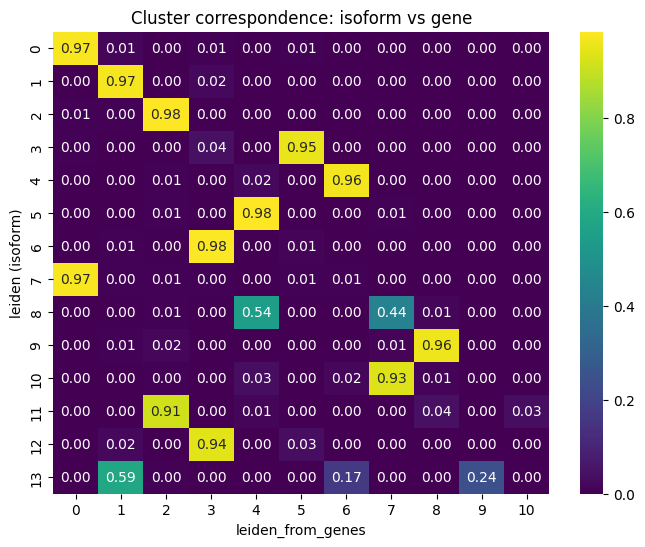

In [ ]:
df = ann_integrated_isoform_data.obs[['leiden', 'leiden_from_genes']]

# Make a cross-tab (counts)
ct = pd.crosstab(df['leiden'], df['leiden_from_genes'])

# Optional: normalize to row sums if you want proportions
ct_norm = ct.div(ct.sum(axis=1), axis=0)

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(ct_norm, annot=True, fmt=".2f", cmap="viridis")
plt.xlabel("leiden_from_genes")
plt.ylabel("leiden (isoform)")
plt.title("Cluster correspondence: isoform vs gene")
plt.show()

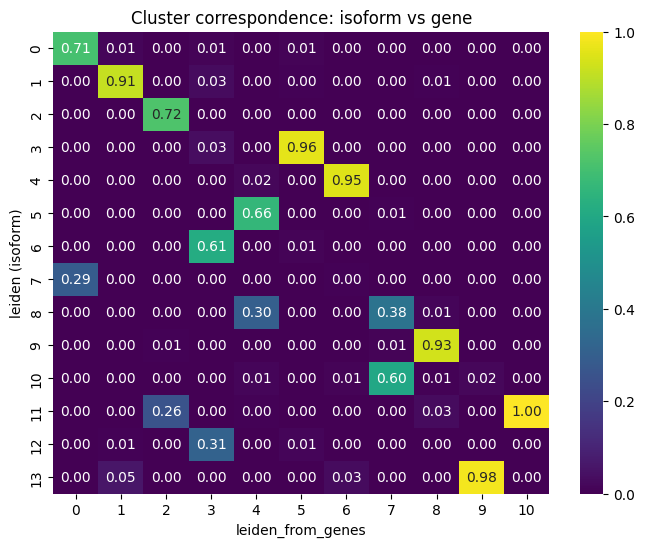

In [80]:
df = ann_integrated_isoform_data.obs[['leiden', 'leiden_from_genes']]

# Make a cross-tab (counts)
ct = pd.crosstab(df['leiden'], df['leiden_from_genes'])

# Optional: normalize to column sums if you want proportions
ct_norm = ct.div(ct.sum(axis=0), axis=1)

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(ct_norm, annot=True, fmt=".2f", cmap="viridis")
plt.xlabel("leiden_from_genes")
plt.ylabel("leiden (isoform)")
plt.title("Cluster correspondence: isoform vs gene")
plt.show()

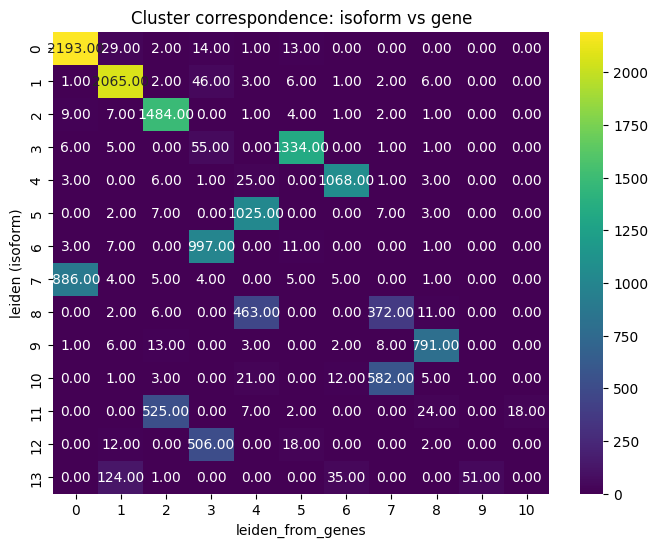

In [78]:
df = ann_integrated_isoform_data.obs[['leiden', 'leiden_from_genes']]

# Make a cross-tab (counts)
ct = pd.crosstab(df['leiden'], df['leiden_from_genes'])

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(ct, annot=True, fmt=".2f", cmap="viridis")
plt.xlabel("leiden_from_genes")
plt.ylabel("leiden (isoform)")
plt.title("Cluster correspondence: isoform vs gene")
plt.show()